# HBV calibration

This notebook is used to calibrate the parameters for the HBV model for the Loire river analysis. The period for calibration is chosen to be from 2015 till 2019, as ERA5 only goes till 2019 for this catchment. 

### 1. Importing general python modules

In [1]:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import geopandas as gpd
import pandas as pd

#niceties
from rich import print

In [2]:
# general eWaterCycle
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing

### 2. Defining experiment data and paths 

In [8]:
# name of the catchment
basin_name = "FR003882"

# defining dates for calibration
experiment_start_date = "2015-01-01T00:00:00Z"
experiment_end_date = "2019-12-31T00:00:00Z"

# defining path for catchment shape file
station_shp = Path.home() / "BEP-Loire" / "book" / "model_loire" / "estreams_cb_FR003882.shp"

# defining destination path for ERA5 data
forcing_path_ERA5 = Path.home() / "forcing" / "loire_river" / "ERA5"
forcing_path_ERA5.mkdir(exist_ok=True)

# model HBV destination path
model_path_HBV = Path.home() / "tmp" / "HBV_model"

gdf = gpd.read_file("estreams_cb_FR003882.shp")
gdf = gdf.to_crs(epsg=2154)
gdf["area_km2"] = gdf.geometry.area / 1e6  
basin_area = gdf["area_km2"].sum()
#print(basin_area)

### 3. Generating ERA5 forcings

In [11]:
# option one: generate forcing:
# ERA5_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].generate(
#    dataset="ERA5",
#    directory= str(forcing_path_ERA5),
#    start_time=experiment_start_date,
#    end_time=experiment_end_date,
#    shape=station_shp,
# )

# get data from stored location
load_location = forcing_path_ERA5 / "work" / "diagnostic" / "script" 
ERA5_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=load_location)

### 4. Defining historical data from eStreams

In [13]:
q_data = pd.read_csv("FR003882_streamflow_m3s.csv", index_col='date', parse_dates=True)[basin_name]
Q_obs = q_data['01-01-2015':'31-12-2019']

### 5. Setting up the model

In [14]:
# Setting the parameters to reasonable values
param_names = ["Imax", "Ce", "Sumax", "Beta", "Pmax", "Tlag", "Kf", "Ks", "FM"]
par_0 = [5, 0.5, 200, 2, 5, 2, 0.1, 0.01, 4]

#               Si,  Su, Sf, Ss, Sp
s_0 = np.array([0,  120,  0,  5,  0])

### 6. Running the model

In [23]:
model = ewatercycle.models.HBV(forcing=ERA5_forcing)
config_file, _ = model.setup(
    parameters=par_0, 
    initial_storage=s_0,
    cfg_dir = model_path_HBV,
)

In [24]:
model.initialize(config_file)

In [25]:
Q_m = []
time = []
while model.time < model.end_time:
    model.update()
    Q_m.append(model.get_value("Q")[0])
    time.append(pd.Timestamp(model.time_as_datetime))

In [26]:
# Stop the model
model.finalize()

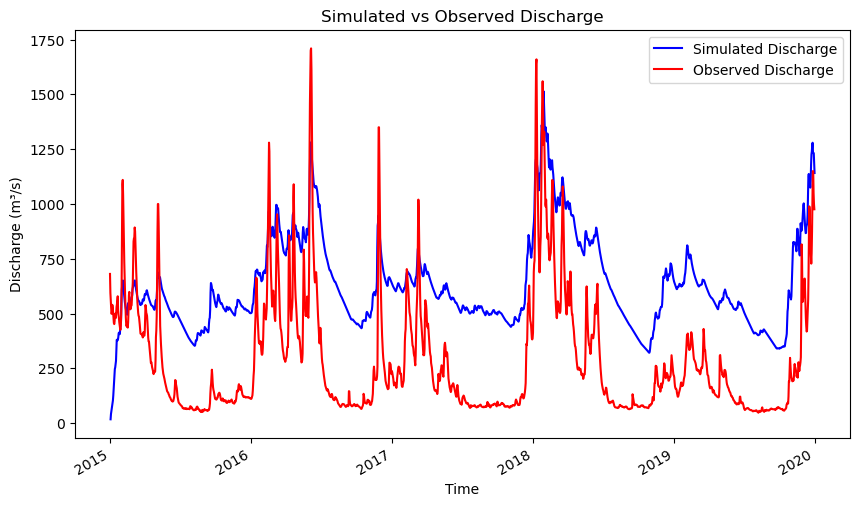

In [27]:
# convert model_output from mm/day to m3/s
model_output = pd.Series(data=Q_m, name="Modelled_discharge", index=time)

def convert_Qsim_mmday_to_m3s(Q_sim_mmday, area_km2):
    return (Q_sim_mmday * area_km2) / 86.4

Q_sim = convert_Qsim_mmday_to_m3s(model_output.values, basin_area)
Q_sim_pd = pd.Series(Q_sim, index=model_output.index, name="Simulated Discharge")

# plot
plt.figure(figsize=(10, 6))
Q_sim_pd.plot(label="Simulated Discharge", color='blue')
Q_obs.plot(label="Observed Discharge", color='red')
plt.title('Simulated vs Observed Discharge')
plt.xlabel('Time')
plt.ylabel('Discharge (m³/s)')
plt.legend()
plt.show()

### 7. Calibrate the parameters

In [22]:
from scipy.optimize import minimize

# NSE log function (focuses on low flows)
def NSE_log(Q_obs, Q_sim, c=0.1):
    return 1 - np.sum((np.log(Q_obs + c) - np.log(Q_sim + c))**2) / np.sum((np.log(Q_obs + c) - np.log(np.mean(Q_obs) + c))**2)

# Objective function to minimize (-NSElog)
def objective_function(params):
    global Q_sim  # Use the already extracted Q_sim
    nse_val = -NSE_log(Q_obs[1:], Q_sim)
    #print(f"Parameters: {params} -> NSE: {nse_val}")
    return nse_val  # Minimize the negative NSElog

# Initial parameter guesses
par_0 = [5, 0.5, 200, 2, 5, 2, 0.1, 0.01, 4]

# Bounds for each parameter (similar to before)
bounds = [(1, 10), (0, 1), (50, 500), (0, 5), (0, 10), (0, 3), (0.01, 1), (0.0001, 0.1), (0.5, 10)]

# Run optimization using Nelder-Mead (or 'L-BFGS-B' for bounds)
result = minimize(objective_function, par_0, method='Nelder-Mead')

# Optimized parameters
optimal_params = result.x
print("Optimized Parameters:", optimal_params)

Optimized Parameters: [5.e+00 5.e-01 2.e+02 2.e+00 5.e+00 2.e+00 1.e-01 1.e-02 4.e+00]